<a href="https://colab.research.google.com/github/stanislavfort/dissect-git-re-basin/blob/master/git_rebasin_Stan_ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Replicating the Git Re-Basin experiments by Stanislav Fort, starting from their codebase (ResNet on CIFAR-10)

I got excited about the Git Re-Basin paper (https://arxiv.org/abs/2209.04836) yesterday (Sep 14 2022) and since the claims seemed pretty strong I decided to replicate the key results. I started from the codebase the authors put on GitHub (https://github.com/samuela/git-re-basin), and took the relevant bits and pieces, put them into a Colab, and write a one-click-runnable replication.

**tldr: I wasn't able to replicate the key observation that the permutation applied to a network moves it to a linearly connected basin of another** 

I added a lot of analysis on top to make sure I knew what was going on. Some things that seem to be true that I wanted to verify: 

1) the permutation procedure preserves the network exactly as it was in terms of its input-ouput behavior, exactly as it should
2) the (network + permutation)'s weight vector gets non-randomly closer to the network towards which the permutation was developed, as it should

However, the key claim that after the permutation is applied the new network is now **within the same convex, linearly connected basin of the other network, I was not able to replicate**. This is unusual since I literally took bits of code from the author's codebase. If you find a problem with my replication, please let me know on Twitter (@stanislavfort) or via email.

Here's the money plot:
Explanation: I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest.
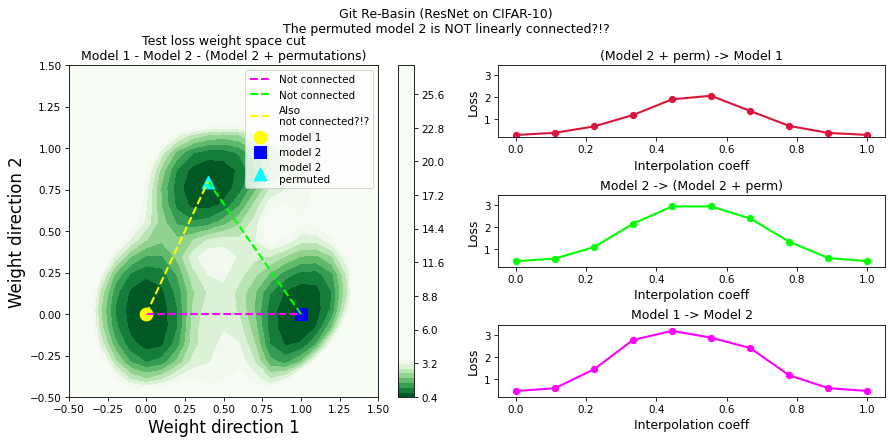


## Library imports

In [1]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done


## Permutation utils

In [2]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [3]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## ResNet model and dataset

In [4]:
from einops import reduce
from flax import linen as nn

def reverse_compose(x, fs):
  for f in fs:
    x = f(x)
  return x

class Block(nn.Module):
  num_channels: int = None
  strides: int = None

  def setup(self):
    self.conv1 = nn.Conv(features=self.num_channels,
                         kernel_size=(3, 3),
                         strides=self.strides,
                         use_bias=False)
    self.norm1 = nn.LayerNorm()
    self.conv2 = nn.Conv(features=self.num_channels, kernel_size=(3, 3), strides=1, use_bias=False)
    self.norm2 = nn.LayerNorm()

    # When strides != 1, then it's 2, which means that we halve the width and height of the input, while doubling the
    # number of channels. Therefore we need to correspondingly halve the width and height of the residuals/shortcut.
    if self.strides != 1:
      assert self.strides == 2

      # Supposedly this is the original description, but it is not easily comaptible with our weight matching stuff
      # since it plays games with the channel structure by padding things around.
      # self.shortcut = lambda x: jnp.pad(x[:, ::2, ::2, :], (
      #     (0, 0), (0, 0), (0, 0), (self.num_channels // 4, self.num_channels // 4)),
      #                                   "constant",
      #                                   constant_values=0)

      # This is not the original, but is fairly common based on other implementations.
      self.shortcut = nn.Sequential([
          nn.Conv(features=self.num_channels,
                  kernel_size=(3, 3),
                  strides=self.strides,
                  use_bias=False),
          nn.LayerNorm()
      ])
    else:
      self.shortcut = lambda x: x

  def __call__(self, x):
    y = x
    y = self.conv1(y)
    y = self.norm1(y)
    y = nn.relu(y)
    y = self.conv2(y)
    y = self.norm2(y)
    return nn.relu(y + self.shortcut(x))

class BlockGroup(nn.Module):
  num_channels: int = None
  num_blocks: int = None
  strides: int = None

  def setup(self):
    assert self.num_blocks > 0
    self.blocks = (
        [Block(num_channels=self.num_channels, strides=self.strides)] +
        [Block(num_channels=self.num_channels, strides=1) for _ in range(self.num_blocks - 1)])

  def __call__(self, x):
    return reverse_compose(x, self.blocks)

class ResNet(nn.Module):
  blocks_per_group: int = None
  num_classes: int = None
  width_multiplier: int = 1

  def setup(self):
    wm = self.width_multiplier

    self.conv1 = nn.Conv(features=16 * wm, kernel_size=(3, 3), use_bias=False)
    self.norm1 = nn.LayerNorm()

    channels_per_group = (16 * wm, 32 * wm, 64 * wm)
    strides_per_group = (1, 2, 2)
    self.blockgroups = [
        BlockGroup(num_channels=c, num_blocks=b, strides=s)
        for c, b, s in zip(channels_per_group, self.blocks_per_group, strides_per_group)
    ]

    self.dense = nn.Dense(self.num_classes)

  def __call__(self, x):
    x = self.conv1(x)
    x = self.norm1(x)
    x = nn.relu(x)
    x = reverse_compose(x, self.blockgroups)
    x = reduce(x, "n h w c -> n c", "mean")
    x = self.dense(x)
    x = nn.log_softmax(x)
    return x

BLOCKS_PER_GROUP = {
    "resnet20": (3, 3, 3),
    "resnet32": (5, 5, 5),
    "resnet44": (7, 7, 7),
    "resnet56": (9, 9, 9),
    "resnet110": (18, 18, 18),
}

In [5]:
import numpy as np
import tensorflow_datasets as tfds

def load_cifar10():
  """Return the training and test datasets, as jnp.array's."""
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("cifar10", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("cifar10", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds

def load_cifar100():
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("cifar100", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("cifar100", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds

def _split_cifar(train_ds, label_split: int):
  """Split a CIFAR-ish dataset into two biased subsets."""
  assert train_ds["images_u8"].shape[0] == 50_000
  assert train_ds["labels"].shape[0] == 50_000

  # We randomly permute the training data, just in case there's some kind of
  # non-iid ordering coming out of tfds.
  perm = np.random.default_rng(123).permutation(50_000)
  train_images_u8 = train_ds["images_u8"][perm, :, :, :]
  train_labels = train_ds["labels"][perm]

  # This just so happens to be a clean 25000/25000 split.
  lt_images_u8 = train_images_u8[train_labels < label_split]
  lt_labels = train_labels[train_labels < label_split]
  gte_images_u8 = train_images_u8[train_labels >= label_split]
  gte_labels = train_labels[train_labels >= label_split]
  s1 = {
      "images_u8": np.concatenate((lt_images_u8[:5000], gte_images_u8[5000:]), axis=0),
      "labels": np.concatenate((lt_labels[:5000], gte_labels[5000:]), axis=0)
  }
  s2 = {
      "images_u8": np.concatenate((gte_images_u8[:5000], lt_images_u8[5000:]), axis=0),
      "labels": np.concatenate((gte_labels[:5000], lt_labels[5000:]), axis=0)
  }
  return s1, s2

def load_cifar10_split():
  train_ds, test_ds = load_cifar10()
  s1, s2 = _split_cifar(train_ds, label_split=5)
  return s1, s2, test_ds

def load_cifar100_split():
  train_ds, test_ds = load_cifar100()
  s1, s2 = _split_cifar(train_ds, label_split=50)
  return s1, s2, test_ds

In [6]:
import argparse

import augmax
import flax
import jax.nn
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
from flax.training.train_state import TrainState
from jax import jit, random, value_and_grad, vmap
from tqdm import tqdm


# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

NUM_CLASSES = 10

In [7]:
def make_stuff(model):
  train_transform = augmax.Chain(
      # augmax does not seem to support random crops with padding. See https://github.com/khdlr/augmax/issues/6.
      augmax.RandomSizedCrop(32, 32, zoom_range=(0.8, 1.2)),
      augmax.HorizontalFlip(),
      augmax.Rotate(),
  )
  # Applied to all input images, test and train.
  normalize_transform = augmax.Chain(augmax.ByteToFloat(), augmax.Normalize())

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    y_onehot = jax.nn.one_hot(labels, NUM_CLASSES)
    logits = model.apply({"params": params}, images_f32)
    l = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == labels)
    return l, {"num_correct": num_correct}

  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    y_onehot = jax.nn.one_hot(labels, NUM_CLASSES)
    logits = model.apply({"params": params}, images_f32)
    l = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == labels)
    return l, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(rng, train_state, images, labels):
    images_transformed = vmap(train_transform)(random.split(rng, images.shape[0]), images)
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_transformed,
                                                            labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits,onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        onehots,
    )

  return {
      "train_transform": train_transform,
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def init_train_state(rng, model, learning_rate, num_epochs, batch_size, num_train_examples,
                     weight_decay: float):
  # See https://github.com/kuangliu/pytorch-cifar.
  warmup_epochs = 5
  steps_per_epoch = num_train_examples // batch_size
  lr_schedule = optax.warmup_cosine_decay_schedule(
      init_value=1e-6,
      peak_value=learning_rate,
      warmup_steps=warmup_epochs * steps_per_epoch,
      # Confusingly, `decay_steps` is actually the total number of steps,
      # including the warmup.
      decay_steps=num_epochs * steps_per_epoch,
  )
  tx = optax.chain(optax.add_decayed_weights(weight_decay), optax.sgd(lr_schedule, momentum=0.9))
  # tx = optax.adamw(learning_rate=lr_schedule, weight_decay=5e-4)
  vars = model.init(rng, jnp.zeros((1, 32, 32, 3)))
  return TrainState.create(apply_fn=model.apply, params=vars["params"], tx=tx)



## Runs details

In [8]:
num_epochs = 100 #100
batch_size = 500
seed = 324232323
config_optimizer = "sgd" #"adam"
learning_rate = 1e-1
weight_decay = 1e-4
width_multiplier = 1

runs_to_collect = 2 #Stan's new stuff

rng = random.PRNGKey(seed)

In [9]:
train_ds, test_ds = load_cifar10()

print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

num_train_examples = train_ds["images_u8"].shape[0]
num_test_examples = test_ds["images_u8"].shape[0]
assert num_train_examples % batch_size == 0
print("num_train_examples", num_train_examples)
print("num_test_examples", num_test_examples)

train_ds labels hash -6926360512441663645
test_ds labels hash 2419992794527428238
num_train_examples 50000
num_test_examples 10000


In [10]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i)

  model = ResNet(blocks_per_group=BLOCKS_PER_GROUP["resnet20"],
                  num_classes=NUM_CLASSES,
                  width_multiplier=width_multiplier)

  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_state = init_train_state(rngmix(rng, f"init{run_i}"),
                                  model=model,
                                  learning_rate=learning_rate,
                                  num_epochs=num_epochs,
                                  batch_size=batch_size,
                                  num_train_examples=train_ds["images_u8"].shape[0],
                                  weight_decay=weight_decay)

  for epoch in tqdm(range(num_epochs)):
    infos = []

    batch_ix = random.permutation(rngmix(rng, f"{run_i}epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    batch_rngs = random.split(rngmix(rng, f"{run_i}batch_rngs-{epoch}"), batch_ix.shape[0])
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      train_state, info = stuff["step"](batch_rngs[i], train_state, images_u8, labels)
      infos.append(info)

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples


    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  1000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  1000)
    
    print(train_loss, train_accuracy, test_loss,test_accuracy)

  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                50_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0


  1%|          | 1/100 [00:23<39:05, 23.70s/it]

1.9600481 0.26639998 1.950713 0.2772


  2%|▏         | 2/100 [00:27<19:33, 11.97s/it]

1.9803509 0.2742 1.9680874 0.28370002


  3%|▎         | 3/100 [00:31<13:17,  8.22s/it]

1.8573103 0.32488 1.8433348 0.33200002


  4%|▍         | 4/100 [00:34<10:19,  6.46s/it]

1.6274984 0.40114 1.6257087 0.39790002


  5%|▌         | 5/100 [00:38<08:41,  5.48s/it]

1.5991634 0.39815998 1.5877829 0.40230003


  6%|▌         | 6/100 [00:42<07:40,  4.90s/it]

1.518769 0.43721998 1.513714 0.43480003


  7%|▋         | 7/100 [00:46<07:00,  4.52s/it]

1.4186678 0.48466 1.4118738 0.4848


  8%|▊         | 8/100 [00:49<06:33,  4.28s/it]

1.4592677 0.45437998 1.4547246 0.46070004


  9%|▉         | 9/100 [00:53<06:14,  4.11s/it]

1.2717043 0.53683996 1.2835209 0.5238


 10%|█         | 10/100 [00:57<05:59,  4.00s/it]

1.2058423 0.56118 1.218188 0.5539


 11%|█         | 11/100 [01:01<05:48,  3.92s/it]

1.1511174 0.58062 1.1644752 0.57430005


 12%|█▏        | 12/100 [01:04<05:40,  3.86s/it]

1.0734544 0.60826 1.0940357 0.59940004


 13%|█▎        | 13/100 [01:08<05:33,  3.83s/it]

0.93100935 0.66704 0.95138043 0.66470003


 14%|█▍        | 14/100 [01:12<05:27,  3.81s/it]

0.9923928 0.65011996 1.0212295 0.63570005


 15%|█▌        | 15/100 [01:16<05:22,  3.79s/it]

0.9306426 0.67168 0.9492245 0.65900004


 16%|█▌        | 16/100 [01:19<05:17,  3.78s/it]

0.97076195 0.65647995 0.99990064 0.6485


 17%|█▋        | 17/100 [01:23<05:12,  3.77s/it]

0.9198095 0.67605996 0.95485026 0.6671


 18%|█▊        | 18/100 [01:27<05:08,  3.76s/it]

0.99681324 0.63942 1.0363532 0.6255


 19%|█▉        | 19/100 [01:31<05:04,  3.76s/it]

0.84507996 0.70436 0.8839328 0.68840003


 20%|██        | 20/100 [01:34<05:00,  3.76s/it]

0.7374483 0.74142 0.78096837 0.7246


 21%|██        | 21/100 [01:38<04:56,  3.76s/it]

0.7326816 0.74347997 0.77854794 0.7243


 22%|██▏       | 22/100 [01:42<04:52,  3.75s/it]

0.71051246 0.75174 0.7559965 0.73800004


 23%|██▎       | 23/100 [01:46<04:48,  3.75s/it]

0.7455147 0.73728 0.7932803 0.72050005


 24%|██▍       | 24/100 [01:49<04:45,  3.75s/it]

0.8429638 0.70676 0.89322436 0.69350004


 25%|██▌       | 25/100 [01:53<04:40,  3.75s/it]

0.68706703 0.76133996 0.73663765 0.74680007


 26%|██▌       | 26/100 [01:57<04:37,  3.75s/it]

0.6902864 0.76054 0.7494577 0.7451


 27%|██▋       | 27/100 [02:01<04:33,  3.75s/it]

0.61762005 0.78274 0.6777347 0.76500005


 28%|██▊       | 28/100 [02:04<04:30,  3.75s/it]

0.60533583 0.78806 0.66207844 0.76830006


 29%|██▉       | 29/100 [02:08<04:26,  3.75s/it]

0.69610125 0.75988 0.7565991 0.7419


 30%|███       | 30/100 [02:12<04:23,  3.76s/it]

0.70907044 0.75681996 0.7779596 0.7386


 31%|███       | 31/100 [02:16<04:19,  3.76s/it]

0.55661756 0.80359995 0.61444324 0.785


 32%|███▏      | 32/100 [02:20<04:16,  3.77s/it]

0.5436823 0.81001997 0.60329443 0.79090005


 33%|███▎      | 33/100 [02:23<04:12,  3.77s/it]

0.5646314 0.80337995 0.63115823 0.78110003


 34%|███▍      | 34/100 [02:27<04:08,  3.76s/it]

0.58594257 0.79481995 0.6487163 0.7752


 35%|███▌      | 35/100 [02:31<04:04,  3.77s/it]

0.5973059 0.79197997 0.66346484 0.7731


 36%|███▌      | 36/100 [02:35<04:00,  3.76s/it]

0.6427513 0.77481997 0.71267766 0.75820005


 37%|███▋      | 37/100 [02:38<03:56,  3.76s/it]

0.5608135 0.80662 0.6255553 0.78800005


 38%|███▊      | 38/100 [02:42<03:52,  3.76s/it]

0.4910996 0.83228 0.5625281 0.80910003


 39%|███▉      | 39/100 [02:46<03:49,  3.76s/it]

0.5618451 0.80583996 0.6289935 0.78330004


 40%|████      | 40/100 [02:50<03:45,  3.76s/it]

0.5223215 0.81729996 0.5964885 0.7943


 41%|████      | 41/100 [02:53<03:41,  3.76s/it]

0.50709313 0.82335997 0.5789587 0.79870003


 42%|████▏     | 42/100 [02:57<03:38,  3.76s/it]

0.52611077 0.81766 0.61499155 0.7946


 43%|████▎     | 43/100 [03:01<03:34,  3.76s/it]

0.5001678 0.82772 0.5830497 0.80310005


 44%|████▍     | 44/100 [03:05<03:30,  3.76s/it]

0.52404004 0.82058 0.61710143 0.79480004


 45%|████▌     | 45/100 [03:08<03:26,  3.76s/it]

0.4834988 0.8305 0.56821007 0.80490005


 46%|████▌     | 46/100 [03:12<03:23,  3.76s/it]

0.5534446 0.80693996 0.6420161 0.78400004


 47%|████▋     | 47/100 [03:16<03:19,  3.76s/it]

0.50942105 0.82681996 0.6095426 0.7972


 48%|████▊     | 48/100 [03:20<03:15,  3.76s/it]

0.46644074 0.83835995 0.56935483 0.8087


 49%|████▉     | 49/100 [03:23<03:11,  3.76s/it]

0.44463167 0.84581995 0.5380774 0.8155


 50%|█████     | 50/100 [03:27<03:07,  3.75s/it]

0.4204114 0.8538 0.5159761 0.8237


 51%|█████     | 51/100 [03:31<03:03,  3.75s/it]

0.4032083 0.8591 0.50434184 0.8274


 52%|█████▏    | 52/100 [03:35<03:00,  3.75s/it]

0.4473521 0.84371996 0.5417821 0.81170005


 53%|█████▎    | 53/100 [03:38<02:56,  3.75s/it]

0.42969382 0.85018 0.53330845 0.8148


 54%|█████▍    | 54/100 [03:42<02:52,  3.75s/it]

0.42654815 0.85332 0.5337633 0.81700003


 55%|█████▌    | 55/100 [03:46<02:48,  3.75s/it]

0.3823622 0.86825997 0.4836255 0.83570004


 56%|█████▌    | 56/100 [03:50<02:45,  3.75s/it]

0.3911623 0.8631 0.4959844 0.82890004


 57%|█████▋    | 57/100 [03:53<02:41,  3.75s/it]

0.392502 0.86399996 0.5026603 0.83210003


 58%|█████▊    | 58/100 [03:57<02:37,  3.75s/it]

0.39276224 0.86494 0.508164 0.83140004


 59%|█████▉    | 59/100 [04:01<02:33,  3.75s/it]

0.42830193 0.8533 0.5459359 0.82140005


 60%|██████    | 60/100 [04:05<02:30,  3.75s/it]

0.4083553 0.86086 0.52047795 0.82650006


 61%|██████    | 61/100 [04:08<02:26,  3.75s/it]

0.36324254 0.87417996 0.4794061 0.83870006


 62%|██████▏   | 62/100 [04:12<02:22,  3.75s/it]

0.42858905 0.85194 0.5412679 0.8202


 63%|██████▎   | 63/100 [04:16<02:18,  3.75s/it]

0.35686398 0.87605995 0.47759563 0.84230006


 64%|██████▍   | 64/100 [04:20<02:15,  3.75s/it]

0.37597218 0.87005997 0.48465857 0.83820003


 65%|██████▌   | 65/100 [04:23<02:11,  3.75s/it]

0.34779477 0.88086 0.46908337 0.84190005


 66%|██████▌   | 66/100 [04:27<02:07,  3.76s/it]

0.3587725 0.87575996 0.47693577 0.8417


 67%|██████▋   | 67/100 [04:31<02:04,  3.76s/it]

0.3566726 0.87696 0.49142516 0.83790004


 68%|██████▊   | 68/100 [04:35<02:00,  3.77s/it]

0.3678875 0.8731 0.501467 0.83390003


 69%|██████▉   | 69/100 [04:39<01:56,  3.77s/it]

0.40977955 0.85631996 0.5440391 0.81610006


 70%|███████   | 70/100 [04:42<01:53,  3.77s/it]

0.33522522 0.88409996 0.459724 0.84720004


 71%|███████   | 71/100 [04:46<01:49,  3.77s/it]

0.30962637 0.89229995 0.4384044 0.85410005


 72%|███████▏  | 72/100 [04:50<01:45,  3.76s/it]

0.305249 0.89438 0.44234586 0.85190004


 73%|███████▎  | 73/100 [04:54<01:41,  3.76s/it]

0.35800475 0.87544 0.5063067 0.8324


 74%|███████▍  | 74/100 [04:57<01:37,  3.75s/it]

0.31419 0.89128 0.45346653 0.84690005


 75%|███████▌  | 75/100 [05:01<01:33,  3.76s/it]

0.3250115 0.88791996 0.4715428 0.84550005


 76%|███████▌  | 76/100 [05:05<01:30,  3.76s/it]

0.30353773 0.89467996 0.451548 0.84900004


 77%|███████▋  | 77/100 [05:09<01:26,  3.76s/it]

0.29199934 0.89912 0.442091 0.85170007


 78%|███████▊  | 78/100 [05:12<01:22,  3.76s/it]

0.3147897 0.89085996 0.46327835 0.8514


 79%|███████▉  | 79/100 [05:16<01:18,  3.75s/it]

0.31125075 0.89207995 0.4610614 0.8489


 80%|████████  | 80/100 [05:20<01:14,  3.75s/it]

0.30610552 0.89342 0.4613326 0.85


 81%|████████  | 81/100 [05:24<01:11,  3.75s/it]

0.30049962 0.89607996 0.45015007 0.851


 82%|████████▏ | 82/100 [05:27<01:07,  3.74s/it]

0.2767437 0.90404 0.42691436 0.8565


 83%|████████▎ | 83/100 [05:31<01:03,  3.75s/it]

0.2969541 0.89791995 0.45634142 0.8528


 84%|████████▍ | 84/100 [05:35<01:00,  3.75s/it]

0.28207463 0.90217996 0.44032067 0.85740006


 85%|████████▌ | 85/100 [05:39<00:56,  3.75s/it]

0.2896231 0.89962 0.4427005 0.85440004


 86%|████████▌ | 86/100 [05:42<00:52,  3.75s/it]

0.28987312 0.89934 0.4472523 0.8525


 87%|████████▋ | 87/100 [05:46<00:48,  3.75s/it]

0.30866554 0.89321995 0.46797395 0.85060006


 88%|████████▊ | 88/100 [05:50<00:44,  3.75s/it]

0.2874932 0.90068 0.44499737 0.85510004


 89%|████████▉ | 89/100 [05:54<00:41,  3.75s/it]

0.27883938 0.90283996 0.43660778 0.8565


 90%|█████████ | 90/100 [05:57<00:37,  3.75s/it]

0.28210014 0.90206 0.44305277 0.85580003


 91%|█████████ | 91/100 [06:01<00:33,  3.75s/it]

0.27556047 0.90411997 0.43603444 0.85730004


 92%|█████████▏| 92/100 [06:05<00:29,  3.75s/it]

0.28232637 0.90199995 0.44661683 0.85400003


 93%|█████████▎| 93/100 [06:09<00:26,  3.75s/it]

0.2750226 0.90466 0.43881676 0.85700005


 94%|█████████▍| 94/100 [06:12<00:22,  3.75s/it]

0.27382913 0.90476 0.43845016 0.85670006


 95%|█████████▌| 95/100 [06:16<00:18,  3.75s/it]

0.27052835 0.90599996 0.43468112 0.85830003


 96%|█████████▌| 96/100 [06:20<00:15,  3.76s/it]

0.27318037 0.90533996 0.43785357 0.85740006


 97%|█████████▋| 97/100 [06:24<00:11,  3.76s/it]

0.2755569 0.90467995 0.43997487 0.85670006


 98%|█████████▊| 98/100 [06:27<00:07,  3.75s/it]

0.2741578 0.90478 0.4389603 0.85780007


 99%|█████████▉| 99/100 [06:31<00:03,  3.75s/it]

0.27327305 0.90562 0.43785125 0.85760003


100%|██████████| 100/100 [06:35<00:00,  3.95s/it]

0.2739435 0.90507996 0.43861222 0.85770005
-----------------
Run 0 DONE!


Run=0 test loss=0.4386122226715088 test accuracy=0.8577000498771667 train loss=0.2739435136318207 train accuracy=0.9050799608230591
--------------------------
Starting run 1


  1%|          | 1/100 [00:11<18:57, 11.49s/it]

2.0225813 0.25438 2.0161586 0.2612


  2%|▏         | 2/100 [00:15<11:19,  6.93s/it]

1.9033734 0.29012 1.8961216 0.2928


  3%|▎         | 3/100 [00:18<08:51,  5.48s/it]

1.766167 0.33574 1.7556208 0.3411


  4%|▍         | 4/100 [00:22<07:40,  4.80s/it]

1.6705557 0.38174 1.6580518 0.38590002


  5%|▌         | 5/100 [00:26<06:59,  4.41s/it]

1.5280756 0.44421998 1.5260361 0.44630003


  6%|▌         | 6/100 [00:30<06:33,  4.19s/it]

1.4970574 0.46282 1.4923103 0.46060002


  7%|▋         | 7/100 [00:33<06:15,  4.04s/it]

1.3354412 0.5071 1.3438389 0.5033


  8%|▊         | 8/100 [00:37<06:02,  3.94s/it]

1.2133166 0.55862 1.22891 0.55120003


  9%|▉         | 9/100 [00:41<05:53,  3.88s/it]

1.22421 0.56022 1.2327446 0.55730003


 10%|█         | 10/100 [00:45<05:45,  3.84s/it]

1.1568303 0.57732 1.1787845 0.5726


 11%|█         | 11/100 [00:48<05:39,  3.81s/it]

1.1000624 0.60238 1.1192312 0.59830004


 12%|█▏        | 12/100 [00:52<05:33,  3.79s/it]

1.1393781 0.59301996 1.167663 0.5855


 13%|█▎        | 13/100 [00:56<05:28,  3.77s/it]

1.0991886 0.60672 1.1166704 0.6032


 14%|█▍        | 14/100 [01:00<05:23,  3.76s/it]

1.0528314 0.61921996 1.076395 0.6108


 15%|█▌        | 15/100 [01:03<05:19,  3.75s/it]

0.9483914 0.66428 0.9780583 0.6498


 16%|█▌        | 16/100 [01:07<05:14,  3.75s/it]

1.037791 0.63724 1.0781524 0.63130003


 17%|█▋        | 17/100 [01:11<05:10,  3.74s/it]

0.9200914 0.67248 0.95922065 0.6624


 18%|█▊        | 18/100 [01:15<05:06,  3.74s/it]

0.94761294 0.67478 0.9960193 0.65970004


 19%|█▉        | 19/100 [01:18<05:02,  3.74s/it]

0.97146094 0.65691996 1.0103252 0.64530003


 20%|██        | 20/100 [01:22<04:58,  3.73s/it]

0.97050804 0.66906 1.0216035 0.66340005


 21%|██        | 21/100 [01:26<04:55,  3.73s/it]

0.9167487 0.67719996 0.97004557 0.66560006


 22%|██▏       | 22/100 [01:29<04:51,  3.73s/it]

0.75991243 0.73424 0.8140546 0.7185


 23%|██▎       | 23/100 [01:33<04:47,  3.74s/it]

0.83039796 0.70919997 0.886815 0.6927


 24%|██▍       | 24/100 [01:37<04:43,  3.74s/it]

0.82188874 0.71068 0.86488694 0.6987


 25%|██▌       | 25/100 [01:41<04:40,  3.74s/it]

0.8388253 0.70239997 0.88836896 0.68780005


 26%|██▌       | 26/100 [01:44<04:36,  3.74s/it]

0.7373422 0.74072 0.79093516 0.72810006


 27%|██▋       | 27/100 [01:48<04:32,  3.74s/it]

0.7708873 0.72804 0.82958394 0.71300006


 28%|██▊       | 28/100 [01:52<04:29,  3.74s/it]

0.7883794 0.72529995 0.8456224 0.7081


 29%|██▉       | 29/100 [01:56<04:25,  3.74s/it]

0.6760848 0.76286 0.7411436 0.73870003


 30%|███       | 30/100 [01:59<04:22,  3.75s/it]

0.66248727 0.76552 0.7259005 0.74840003


 31%|███       | 31/100 [02:03<04:18,  3.74s/it]

0.613104 0.78502 0.67956907 0.7627


 32%|███▏      | 32/100 [02:07<04:14,  3.74s/it]

0.712697 0.75468 0.7722841 0.73910004


 33%|███▎      | 33/100 [02:11<04:10,  3.74s/it]

0.72766185 0.74846 0.78959423 0.73530006


 34%|███▍      | 34/100 [02:14<04:06,  3.74s/it]

0.55093837 0.80816 0.62132424 0.7831


 35%|███▌      | 35/100 [02:18<04:04,  3.77s/it]

0.60282975 0.78818 0.67428267 0.7717


 36%|███▌      | 36/100 [02:22<04:00,  3.75s/it]

0.57451874 0.79943997 0.64722174 0.77390003


 37%|███▋      | 37/100 [02:26<03:56,  3.75s/it]

0.5411779 0.81136 0.612166 0.7936


 38%|███▊      | 38/100 [02:29<03:52,  3.75s/it]

0.52389145 0.81825995 0.6022829 0.78990006


 39%|███▉      | 39/100 [02:33<03:48,  3.75s/it]

0.53114855 0.8153 0.60533386 0.7892


 40%|████      | 40/100 [02:37<03:45,  3.75s/it]

0.5830028 0.79994 0.65739894 0.77900004


 41%|████      | 41/100 [02:41<03:41,  3.75s/it]

0.46761787 0.839 0.5407487 0.81540006


 42%|████▏     | 42/100 [02:44<03:37,  3.76s/it]

0.48516914 0.83092 0.5648613 0.808


 43%|████▎     | 43/100 [02:48<03:33,  3.75s/it]

0.5457937 0.81078 0.63284945 0.78770006


 44%|████▍     | 44/100 [02:52<03:30,  3.76s/it]

0.49400088 0.8269 0.5794761 0.8015


 45%|████▌     | 45/100 [02:56<03:26,  3.75s/it]

0.49554142 0.83001995 0.58533996 0.8022


 46%|████▌     | 46/100 [02:59<03:22,  3.74s/it]

0.56961435 0.80534 0.6592793 0.7828


 47%|████▋     | 47/100 [03:03<03:18,  3.74s/it]

0.542868 0.81272 0.6315183 0.78700006


 48%|████▊     | 48/100 [03:07<03:14,  3.75s/it]

0.4756073 0.8346 0.5606964 0.8108


 49%|████▉     | 49/100 [03:11<03:11,  3.75s/it]

0.51952344 0.82106 0.61674786 0.7929


 50%|█████     | 50/100 [03:14<03:07,  3.75s/it]

0.432577 0.85003996 0.5310113 0.81880003


 51%|█████     | 51/100 [03:18<03:03,  3.75s/it]

0.45051804 0.84533995 0.5490087 0.8162


 52%|█████▏    | 52/100 [03:22<02:59,  3.75s/it]

0.52992165 0.81549996 0.6320929 0.7893


 53%|█████▎    | 53/100 [03:26<02:56,  3.75s/it]

0.47340068 0.83668 0.56550837 0.8054


 54%|█████▍    | 54/100 [03:29<02:52,  3.75s/it]

0.4509469 0.8463 0.5555042 0.8141


 55%|█████▌    | 55/100 [03:33<02:48,  3.75s/it]

0.3863199 0.86592 0.48562777 0.83540004


 56%|█████▌    | 56/100 [03:37<02:44,  3.75s/it]

0.38373804 0.8663 0.49508527 0.83190006


 57%|█████▋    | 57/100 [03:41<02:41,  3.75s/it]

0.4285982 0.85284 0.54559904 0.81900007


 58%|█████▊    | 58/100 [03:44<02:37,  3.75s/it]

0.40413198 0.85916 0.5174361 0.8234


 59%|█████▉    | 59/100 [03:48<02:33,  3.74s/it]

0.45663416 0.84183997 0.5616256 0.8108


 60%|██████    | 60/100 [03:52<02:29,  3.74s/it]

0.39971644 0.86244 0.52259785 0.82780004


 61%|██████    | 61/100 [03:56<02:25,  3.74s/it]

0.3837218 0.86744 0.49369207 0.83330005


 62%|██████▏   | 62/100 [03:59<02:21,  3.74s/it]

0.37925726 0.87024 0.5026074 0.83300006


 63%|██████▎   | 63/100 [04:03<02:18,  3.74s/it]

0.40283796 0.8591 0.52464205 0.82760006


 64%|██████▍   | 64/100 [04:07<02:14,  3.74s/it]

0.36820936 0.87156 0.48535535 0.83870006


 65%|██████▌   | 65/100 [04:11<02:10,  3.74s/it]

0.3689468 0.87152 0.48482215 0.84020007


 66%|██████▌   | 66/100 [04:14<02:06,  3.74s/it]

0.3699313 0.8699 0.49202907 0.83820003


 67%|██████▋   | 67/100 [04:18<02:03,  3.74s/it]

0.37644422 0.86939996 0.5052288 0.83030003


 68%|██████▊   | 68/100 [04:22<01:59,  3.74s/it]

0.35794216 0.87737995 0.4840718 0.84160006


 69%|██████▉   | 69/100 [04:26<01:55,  3.74s/it]

0.34132344 0.88214 0.4759633 0.84150004


 70%|███████   | 70/100 [04:29<01:52,  3.74s/it]

0.3654391 0.87456 0.5050775 0.83640003


 71%|███████   | 71/100 [04:33<01:48,  3.74s/it]

0.40017217 0.86406 0.541604 0.82830006


 72%|███████▏  | 72/100 [04:37<01:44,  3.74s/it]

0.3593408 0.87523997 0.5081094 0.8385


 73%|███████▎  | 73/100 [04:40<01:40,  3.74s/it]

0.36858615 0.87149996 0.50141364 0.83370006


 74%|███████▍  | 74/100 [04:44<01:37,  3.74s/it]

0.3499907 0.87696 0.49058607 0.83970004


 75%|███████▌  | 75/100 [04:48<01:33,  3.74s/it]

0.35865974 0.87777996 0.5033077 0.83900005


 76%|███████▌  | 76/100 [04:52<01:29,  3.74s/it]

0.3075169 0.89243996 0.45572403 0.8507


 77%|███████▋  | 77/100 [04:55<01:25,  3.73s/it]

0.32080254 0.8878 0.4635135 0.84790003


 78%|███████▊  | 78/100 [04:59<01:22,  3.73s/it]

0.31357014 0.89221996 0.460481 0.84870005


 79%|███████▉  | 79/100 [05:03<01:18,  3.73s/it]

0.32302317 0.88716 0.4681615 0.84520006


 80%|████████  | 80/100 [05:07<01:14,  3.74s/it]

0.30711424 0.89216 0.4613328 0.84940004


 81%|████████  | 81/100 [05:10<01:10,  3.73s/it]

0.32375425 0.88812 0.47588405 0.84770006


 82%|████████▏ | 82/100 [05:14<01:07,  3.74s/it]

0.30113715 0.89484 0.4538795 0.8528


 83%|████████▎ | 83/100 [05:18<01:03,  3.74s/it]

0.30004838 0.89559996 0.44750598 0.85350007


 84%|████████▍ | 84/100 [05:22<00:59,  3.74s/it]

0.30706328 0.89334 0.46398625 0.85020006


 85%|████████▌ | 85/100 [05:25<00:56,  3.74s/it]

0.28760973 0.89988 0.44475314 0.85590005


 86%|████████▌ | 86/100 [05:29<00:52,  3.74s/it]

0.28934196 0.8994 0.4442484 0.85710007


 87%|████████▋ | 87/100 [05:33<00:48,  3.74s/it]

0.286367 0.90088 0.4449367 0.85530007


 88%|████████▊ | 88/100 [05:37<00:44,  3.74s/it]

0.2753207 0.90455997 0.43528986 0.85830003


 89%|████████▉ | 89/100 [05:40<00:41,  3.74s/it]

0.2899881 0.89905995 0.45268264 0.8546


 90%|█████████ | 90/100 [05:44<00:37,  3.73s/it]

0.28812417 0.90019995 0.4482329 0.8557


 91%|█████████ | 91/100 [05:48<00:33,  3.74s/it]

0.28797755 0.89984 0.4513857 0.85510004


 92%|█████████▏| 92/100 [05:51<00:29,  3.74s/it]

0.2782905 0.90349996 0.43835345 0.85950005


 93%|█████████▎| 93/100 [05:55<00:26,  3.73s/it]

0.28261396 0.90186 0.44350025 0.8564


 94%|█████████▍| 94/100 [05:59<00:22,  3.73s/it]

0.27392098 0.90507996 0.4355137 0.85800004


 95%|█████████▌| 95/100 [06:03<00:18,  3.74s/it]

0.2798487 0.90353996 0.44161355 0.85630006


 96%|█████████▌| 96/100 [06:06<00:14,  3.74s/it]

0.27642867 0.9041 0.4370064 0.85800004


 97%|█████████▋| 97/100 [06:10<00:11,  3.73s/it]

0.28280145 0.90173995 0.44463235 0.85660005


 98%|█████████▊| 98/100 [06:14<00:07,  3.73s/it]

0.28080276 0.90235996 0.44220442 0.8568


 99%|█████████▉| 99/100 [06:18<00:03,  3.74s/it]

0.27827588 0.90331995 0.43978673 0.8575


100%|██████████| 100/100 [06:21<00:00,  3.82s/it]

0.27799225 0.90344 0.43949583 0.85710007
-----------------
Run 1 DONE!


Run=1 test loss=0.43949583172798157 test accuracy=0.8571000695228577 train loss=0.27799224853515625 train accuracy=0.903439998626709


In [11]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [12]:
permutation_spec = resnet20_permutation_spec()
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_blockgroups_1/blocks_1_inner: 9.383745193481445
0/P_blockgroups_0/blocks_1_inner: 6.745140552520752
0/P_bg1: 25.023895263671875
0/P_bg2: 123.17475891113281
0/P_blockgroups_2/blocks_0_inner: 22.021766662597656
0/P_blockgroups_1/blocks_0_inner: 11.9639892578125
0/P_blockgroups_1/blocks_2_inner: 7.765949249267578
0/P_blockgroups_2/blocks_1_inner: 23.88787078857422
0/P_blockgroups_0/blocks_0_inner: 11.391504287719727
0/P_bg0: 34.4544677734375
0/P_blockgroups_0/blocks_2_inner: 5.992781639099121
0/P_blockgroups_2/blocks_2_inner: 18.76821517944336
1/P_blockgroups_0/blocks_0_inner: 11.408641815185547
1/P_blockgroups_0/blocks_1_inner: 4.181341171264648
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 7.286396026611328
1/P_bg2: 0.68817138671875
1/P_bg1: 4.4359588623046875
1/P_blockgroups_1/blocks_2_inner: 2.3572235107421875
1/P_blockgroups_2/blocks_0_inner: 5.60699462890625
1/P_bg0: 0.0
1/P_blockgroups_0/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_0_inner: 5.041790008

In [13]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [14]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  50_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=0.2739435136318207 train_accuracy=0.9050799608230591
test_loss=0.4386122226715088 test_accuracy=0.8577000498771667


### Model 2

In [15]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  50_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=0.27799224853515625 train_accuracy=0.903439998626709
test_loss=0.43949583172798157 test_accuracy=0.8571000695228577


### Model 1 with permutation

In [16]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  50_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=0.2739435136318207 train_accuracy=0.9050799608230591
test_loss=0.4386122226715088 test_accuracy=0.8577000498771667


### Model 2 with permutation

In [17]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  50_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.27799224853515625 train_accuracy=0.903439998626709
test_loss=0.43949583172798157 test_accuracy=0.8571000695228577


## Weight vector analysis

In [18]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [19]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [20]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=2300.77978515625
model 2 length**2=2322.551025390625
model 1 + perms length**2=2300.77978515625
model 2 + perms length**2=2322.551025390625


In [21]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=0.9999999403953552
cos(model 1,model 2)=0.22063489258289337
cos(model 1,model 1 + perms)=0.22538278996944427
cos(model 1,model 2 + perms)=0.37794676423072815
cos(model 2,model 1)=0.22063489258289337
cos(model 2,model 2)=1.0000001192092896
cos(model 2,model 1 + perms)=0.23296894133090973
cos(model 2,model 2 + perms)=0.22487665712833405
cos(model 1 + perms,model 1)=0.22538278996944427
cos(model 1 + perms,model 2)=0.23296895623207092
cos(model 1 + perms,model 1 + perms)=0.9999999403953552
cos(model 1 + perms,model 2 + perms)=0.22063489258289337
cos(model 2 + perms,model 1)=0.37794676423072815
cos(model 2 + perms,model 2)=0.22487665712833405
cos(model 2 + perms,model 1 + perms)=0.22063489258289337
cos(model 2 + perms,model 2 + perms)=1.0000001192092896


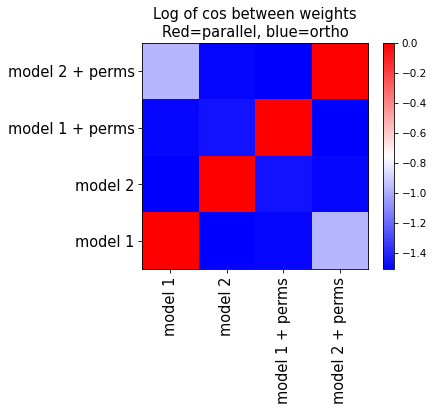

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,4),dpi=75)
fig.patch.set_facecolor('white')
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [23]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.43861222
1 0.1111111111111111 0.56399626
2 0.2222222222222222 1.4288167
3 0.3333333333333333 2.774155
4 0.4444444444444444 3.1908705
5 0.5555555555555556 2.8816588
6 0.6666666666666666 2.4040842
7 0.7777777777777777 1.1570084
8 0.8888888888888888 0.5715954
9 1.0 0.43949583


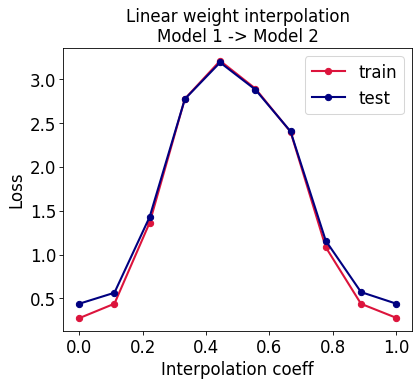

In [24]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.43861222
1 0.1111111111111111 0.5185892
2 0.2222222222222222 0.77421075
3 0.3333333333333333 1.2638193
4 0.4444444444444444 1.9611313
5 0.5555555555555556 2.123329
6 0.6666666666666666 1.4516547
7 0.7777777777777777 0.80233204
8 0.8888888888888888 0.50996816
9 1.0 0.43949583


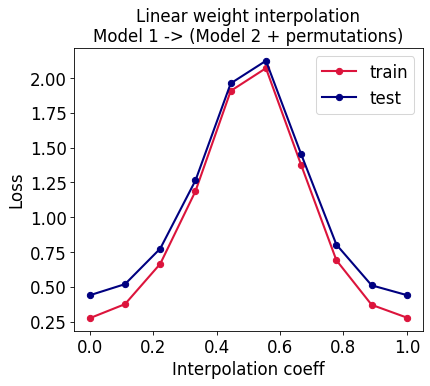

In [25]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 0.43949583
1 0.1111111111111111 0.5587744
2 0.2222222222222222 1.0812563
3 0.3333333333333333 2.1511667
4 0.4444444444444444 2.94468
5 0.5555555555555556 2.945131
6 0.6666666666666666 2.3950164
7 0.7777777777777777 1.3261898
8 0.8888888888888888 0.5848454
9 1.0 0.43949583


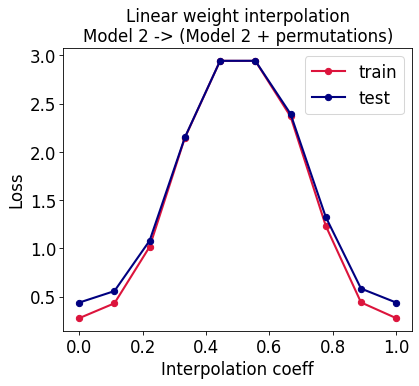

In [26]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 0.43949583
1 0.1111111111111111 0.5824039
2 0.2222222222222222 1.1070184
3 0.3333333333333333 2.0315135
4 0.4444444444444444 2.866737
5 0.5555555555555556 3.2358391
6 0.6666666666666666 2.7158277
7 0.7777777777777777 1.3661505
8 0.8888888888888888 0.5624008
9 1.0 0.43861222


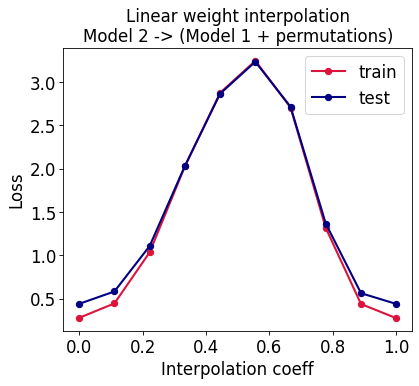

In [27]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.43861222
1 0.1111111111111111 0.5923441
2 0.2222222222222222 1.2699018
3 0.3333333333333333 2.195657
4 0.4444444444444444 2.5431979
5 0.5555555555555556 2.551907
6 0.6666666666666666 2.0839512
7 0.7777777777777777 1.0988057
8 0.8888888888888888 0.5447632
9 1.0 0.43861222


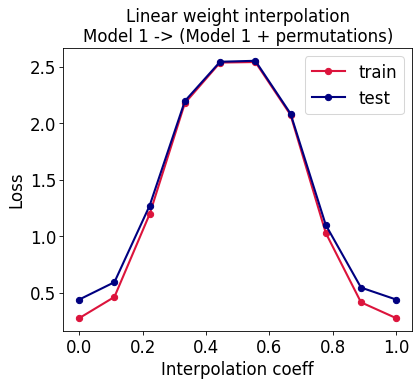

In [28]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [29]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [30]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=1219
Disagreemnt model 1 vs model 1 + perms=0
Disagreemnt model 1 vs model 2 + perms=1219
Disagreemnt model 2 vs model 1=1219
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=1219
Disagreemnt model 2 vs model 2 + perms=0
Disagreemnt model 1 + perms vs model 1=0
Disagreemnt model 1 + perms vs model 2=1219
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=1219
Disagreemnt model 2 + perms vs model 1=1219
Disagreemnt model 2 + perms vs model 2=0
Disagreemnt model 2 + perms vs model 1 + perms=1219
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [31]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [32]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Cut model1 - model2 - (model2+perm)

In [33]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


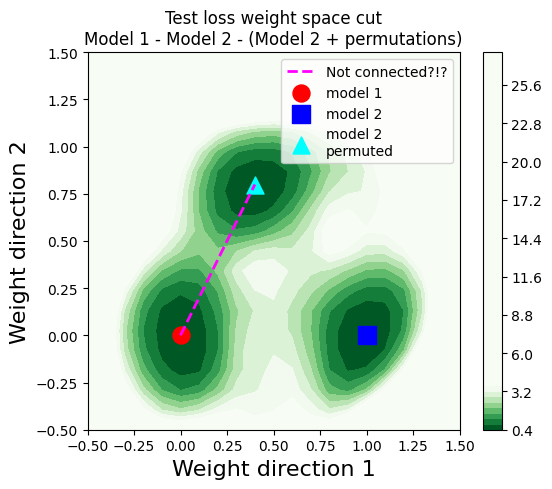

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=3.5,levels=70)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

## Combined plot

In [35]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    50_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


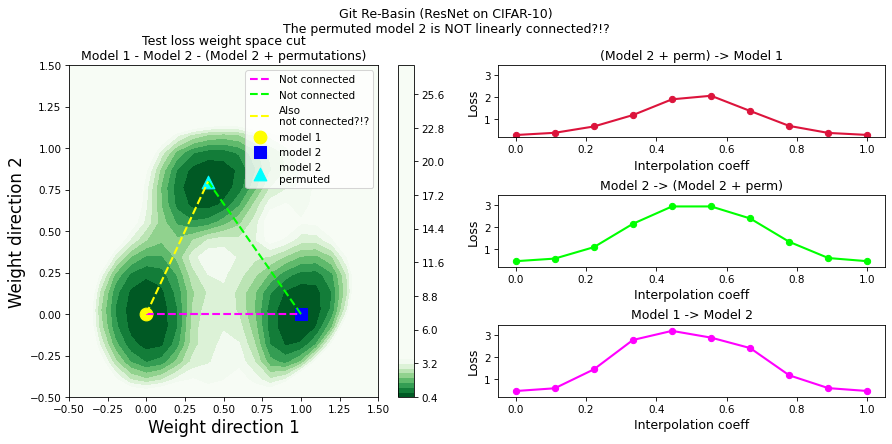

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (ResNet on CIFAR-10)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=3.5,levels=70)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="yellow",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()